In [19]:
# Importing libraries
!pip install ultralytics

In [20]:
import os
HOME = os.getcwd()

In [24]:
# install bytetrack
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [26]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass

In [27]:
# install roboflow supervision
!pip install supervision==0.1.0

In [29]:
# get video
source_video_path = "/content/drive/MyDrive/object_detection/Road_traffic_video.mp4"

## Load yolo pretrained model

In [30]:
# yolo model
MODEL = "yolov8x.pt"

In [31]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:02<00:00, 48.2MB/s]


YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [32]:
!yolo task=detect mode=predict model=yolov8x.pt conf=0.25 source={source_video_path}

Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs

video 1/1 (1/9184) /content/drive/MyDrive/object_detection/Road_traffic_video.mp4: 384x640 8 cars, 4433.9ms
video 1/1 (2/9184) /content/drive/MyDrive/object_detection/Road_traffic_video.mp4: 384x640 8 cars, 2876.1ms
video 1/1 (3/9184) /content/drive/MyDrive/object_detection/Road_traffic_video.mp4: 384x640 8 cars, 2738.6ms
video 1/1 (4/9184) /content/drive/MyDrive/object_detection/Road_traffic_video.mp4: 384x640 8 cars, 2776.6ms
video 1/1 (5/9184) /content/drive/MyDrive/object_detection/Road_traffic_video.mp4: 384x640 8 cars, 3262.5ms
video 1/1 (6/9184) /content/drive/MyDrive/object_detection/Road_traffic_video.mp4: 384x640 8 cars, 3832.1ms
video 1/1 (7/9184) /content/drive/MyDrive/object_detection/Road_traffic_video.mp4: 384x640 8 cars, 2812.4ms
video 1/1 (8/9184) /content/drive/MyDrive/object_detection/Road_traffic_vid

In [15]:
from supervision.video.source import get_video_frames_generator
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.draw.color import ColorPalette

In [16]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
# class_ids of interest - car, motorcycle, bus and truck
CLASS_ID = [2, 3, 5, 7]


0: 384x640 8 cars, 146.9ms
Speed: 1.7ms preprocess, 146.9ms inference, 905.8ms postprocess per image at shape (1, 3, 384, 640)


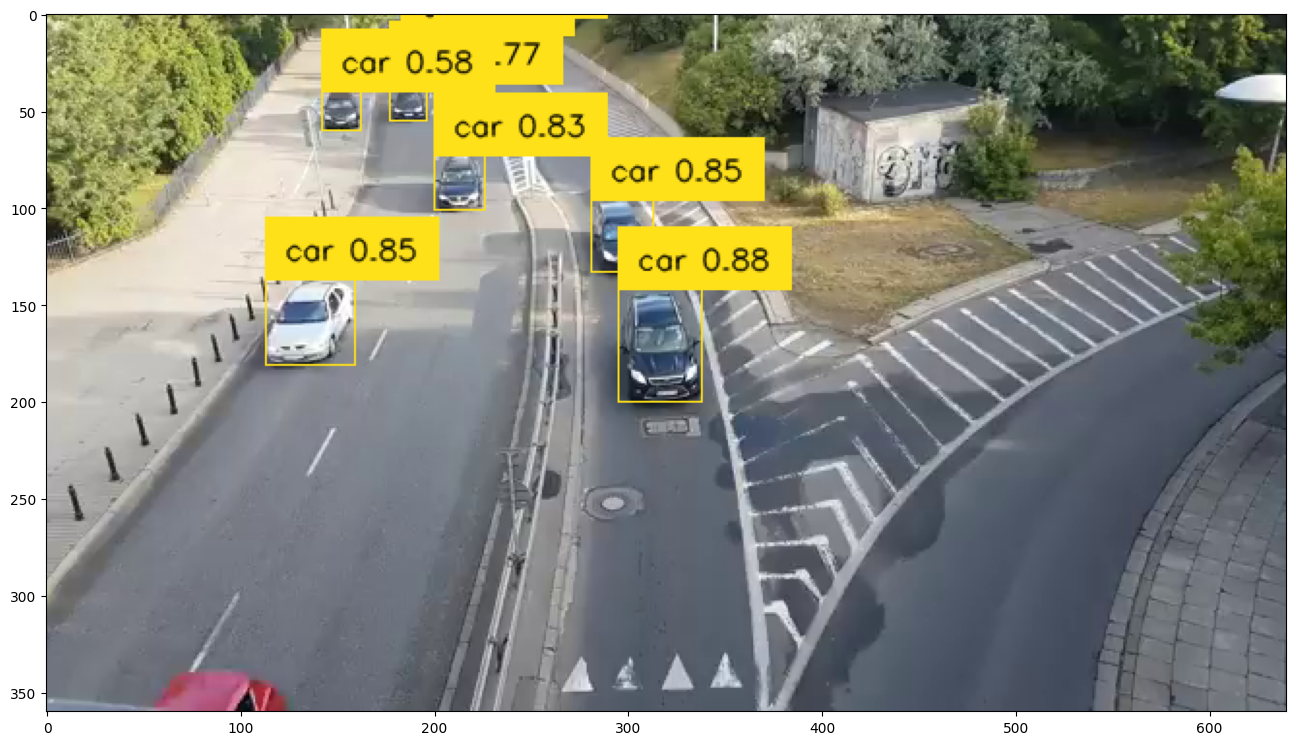

In [17]:
# create frame generator
generator = get_video_frames_generator(source_video_path)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=1, text_thickness=1, text_scale=0.5)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))